<a href="https://colab.research.google.com/github/abhigyan2003/keystroke/blob/main/state_multiple_sessions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo pandas scikit-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [41]:
import pandas as pd

# === Load User 7 Sessions ===
u7_s1 = pd.read_csv("session_0041905381.csv")
u7_s2 = pd.read_csv("session_1060325796.csv")
u7_s3 = pd.read_csv("session_3320405034.csv")
u7_s4 = pd.read_csv("session_3826583375.csv")
u7_s5 = pd.read_csv("session_6668463071.csv")
u7_s6 = pd.read_csv("session_8961330453.csv")
u7_s7 = pd.read_csv("session_9017095287.csv")

# === Load User 9 Sessions ===
u9_s1 = pd.read_csv("session_0335985747.csv")
u9_s2 = pd.read_csv("session_3390119815.csv")
u9_s3 = pd.read_csv("session_3879637058.csv")
u9_s4 = pd.read_csv("session_4373781904.csv")
u9_s5 = pd.read_csv("session_5155383252.csv")
u9_s6 = pd.read_csv("session_7285432516.csv")
u9_s7 = pd.read_csv("session_8764610836.csv")

# === Add User Labels ===
for df in [u7_s1, u7_s2, u7_s3, u7_s4, u7_s5, u7_s6, u7_s7]:
    df["User"] = 7

for df in [u9_s1, u9_s2, u9_s3, u9_s4, u9_s5, u9_s6, u9_s7]:
    df["User"] = 9

# === Combine All Sessions ===
df = pd.concat([
    u7_s1, u7_s2, u7_s3, u7_s4, u7_s5, u7_s6, u7_s7,
    u9_s1, u9_s2, u9_s3, u9_s4, u9_s5, u9_s6, u9_s7
], ignore_index=True)

# === Check Unique Mouse States ===
print("🖱️ Unique states:", df["state"].unique())


['Move' 'Pressed' 'Released' 'Drag']


In [57]:
import pandas as pd
import os

# List of your session file names
session_files = [
    "session_0041905381.csv", "session_1060325796.csv", "session_3320405034.csv",
    "session_3826583375.csv", "session_6668463071.csv", "session_8961330453.csv", "session_9017095287.csv",
    "session_0335985747.csv", "session_3390119815.csv", "session_3879637058.csv",
    "session_4373781904.csv", "session_5155383252.csv", "session_7285432516.csv", "session_8764610836.csv"
]

# Print header
print(f"{'Filename':<30} | {'Samples'}")
print("-" * 45)

# Loop through each file and count rows
for file in session_files:
    try:
        df = pd.read_csv(file)
        print(f"{file:<30} | {len(df)}")
    except Exception as e:
        print(f"{file:<30} | ❌ Error: {e}")


Filename                       | Samples
---------------------------------------------
session_0041905381.csv         | 77687
session_1060325796.csv         | 40747
session_3320405034.csv         | 60361
session_3826583375.csv         | 54258
session_6668463071.csv         | 50735
session_8961330453.csv         | 45887
session_9017095287.csv         | 64099
session_0335985747.csv         | 53055
session_3390119815.csv         | 55546
session_3879637058.csv         | 69725
session_4373781904.csv         | 55619
session_5155383252.csv         | 58744
session_7285432516.csv         | 55907
session_8764610836.csv         | 54782


In [54]:
df


,record timestamp,client timestamp,button,state,x,y,User,StateEncoded,UserEncoded
0,0.000,0.000,NoButton,Move,126,337,7,1,0
1,0.000,0.016,NoButton,Move,129,337,7,1,0
2,0.000,0.032,NoButton,Move,136,337,7,1,0
3,0.000,0.047,NoButton,Move,155,339,7,1,0
4,0.000,0.063,NoButton,Move,185,340,7,1,0
...,...,...,...,...,...,...,...,...,...
249618,3330.383,3330.278,NoButton,Move,721,268,9,1,1
249619,3330.383,3330.294,NoButton,Move,722,268,9,1,1
249620,3330.383,3330.294,NoButton,Move,722,267,9,1,1
249621,3330.383,3330.403,Left,Pressed,722,267,9,2,1


In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# === Parameters ===
SEQ_LEN = 50
feature_col = "StateEncoded"
label_col = "UserEncoded"

# === Session files (replace with your actual file paths) ===
session_files = [
    "session_0041905381.csv", "session_1060325796.csv", "session_3320405034.csv",
    "session_3826583375.csv", "session_6668463071.csv", "session_8961330453.csv", "session_9017095287.csv",
    "session_0335985747.csv", "session_3390119815.csv", "session_3879637058.csv",
    "session_4373781904.csv", "session_5155383252.csv", "session_7285432516.csv", "session_8764610836.csv"
]

# === Load & label data ===
dataframes = []
for f in session_files:
    df = pd.read_csv(f)

    # Identify user from file name (basic heuristic)
    if "session_0" in f:  # customize this condition if needed
        if int(f.split("_")[1][0]) < 5:
            df["User"] = 7
        else:
            df["User"] = 9

    df["SessionID"] = f  # track session origin
    dataframes.append(df)

# Combine all
df_all = pd.concat(dataframes, ignore_index=True)

# Encode 'state' and 'user'
le_state = LabelEncoder()
df_all["StateEncoded"] = le_state.fit_transform(df_all["state"])

le_user = LabelEncoder()
df_all["UserEncoded"] = le_user.fit_transform(df_all["User"])

print("✅ Loaded all sessions. Total rows:", len(df_all))

# === Build sequences per session ===
X, y = [], []

for session_id in df_all["SessionID"].unique():
    session_df = df_all[df_all["SessionID"] == session_id]
    states = session_df[feature_col].values
    users = session_df[label_col].values

    for i in range(len(states) - SEQ_LEN):
        seq = states[i:i + SEQ_LEN]
        label = users[i + SEQ_LEN - 1]  # label from end of sequence
        X.append(seq)
        y.append(label)

# Convert to arrays
X = np.array(X)
y = np.array(y)

print(f"✅ Final shapes — X: {X.shape}, y: {y.shape}")


✅ Loaded all sessions. Total rows: 797152
✅ Final shapes — X: (796452, 50), y: (796452,)


In [60]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

X_tensor = torch.tensor(X, dtype=torch.long)  # Long because it's categorical
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)

In [61]:
print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))


Training samples: 637161
Validation samples: 159291


In [62]:
# Convert to numpy for easy class counts
train_labels = [y_tensor[i].item() for i in train_ds.indices]
val_labels = [y_tensor[i].item() for i in val_ds.indices]

# Print class distributions
from collections import Counter

print("Train class distribution:", Counter(train_labels))
print("Validation class distribution:", Counter(val_labels))

Train class distribution: Counter({1: 532722, 0: 104439})
Validation class distribution: Counter({1: 133088, 0: 26203})


In [63]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Assuming y is your label array (already built during sequence prep)
class_weights_np = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights_np, dtype=torch.float)
print("Class Weights:", class_weights)


Class Weights: tensor([3.0482, 0.5981])


In [64]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -math.log(10000.0) / d_model)
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
        # q: (batch, head, seq_len_q, d_k)
        # k: (batch, head, seq_len_k, d_k)
        # v: (batch, head, seq_len_v, d_v)

        # Scaled dot product
        attn = torch.matmul(q, k.transpose(2, 3)) / self.temperature

        # Apply mask (optional)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, float('-inf'))  # better for stability

        # Softmax along last dimension (seq_len_k) for each query
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        # Weighted sum of values
        output = torch.matmul(attn, v)

        return output, attn

In [66]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        # Linear layers for projecting input to Q, K, V
        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)

        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        # Scaled dot-product attention
        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        bsz, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        # Save residual
        residual = q

        # Linear projections and reshape for multi-head
        q = self.w_qs(q).view(bsz, len_q, n_head, d_k).transpose(1, 2)  # (bsz, n_head, len_q, d_k)
        k = self.w_ks(k).view(bsz, len_k, n_head, d_k).transpose(1, 2)
        v = self.w_vs(v).view(bsz, len_v, n_head, d_v).transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)  # broadcast mask to all heads

        # Apply attention on all the projected vectors
        q, attn = self.attention(q, k, v, mask=mask)

        # Concatenate heads and put through final linear layer
        q = q.transpose(1, 2).contiguous().view(bsz, len_q, -1)
        q = self.dropout(self.fc(q))
        q = self.layer_norm(q + residual)  # Add & Norm

        return q, attn

In [67]:
class PositionwiseFeedForward(nn.Module):
    ''' Feed Forward layer used inside each encoder/decoder block '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_in)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)

    def forward(self, x):
        residual = x
        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x = self.layer_norm(x + residual)
        return x

In [68]:
class EncoderLayer(nn.Module):
    ''' One Encoder Layer = Multi-head Attention + Feed Forward '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super().__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        # Apply self-attention
        enc_output, enc_slf_attn = self.slf_attn(enc_input, enc_input, enc_input, mask=slf_attn_mask)

        # Apply position-wise feed-forward
        enc_output = self.pos_ffn(enc_output)

        return enc_output, enc_slf_attn

In [69]:
import torch
import torch.nn as nn

class MouseDynamicsClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes=2, d_model=64, num_heads=4, num_layers=2, d_inner=128, dropout=0.1, max_len=50):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)  # NEW: Embed state integers
        self.pos_enc = PositionalEncoding(d_model, max_len=max_len)  # Positional encoding stays

        d_k = d_v = d_model // num_heads

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, d_inner, num_heads, d_k, d_v, dropout=dropout)
            for _ in range(num_layers)
        ])

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):  # x: [B, seq_len] where each token is a state_id
        x = self.embedding(x)       # [B, seq_len, d_model]
        x = self.pos_enc(x)         # [B, seq_len, d_model]

        for layer in self.encoder_layers:
            x, _ = layer(x)         # [B, seq_len, d_model]

        x = x.mean(dim=1)           # [B, d_model]
        return self.classifier(x)   # [B, 2]


In [70]:
# 1. Import if not already
import torch.nn as nn
import torch

# 2. Move model to device (if not already done)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Initialize the model (pass vocab_size for state embeddings)
vocab_size = len(le_state.classes_)  # Number of unique states
model = MouseDynamicsClassifier(vocab_size=vocab_size, num_classes=2).to(device)

# 4. Define loss function using previously computed class_weights (make sure class_weights is a tensor on device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

# 5. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [71]:
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA Device Name: Tesla T4


In [72]:
from tqdm.auto import tqdm

def train(model, train_dl, val_dl, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # === Validation ===
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                predicted = preds.argmax(1)
                correct += (predicted == yb).sum().item()
                total += yb.size(0)

        acc = correct / total
        print(f"✅ Epoch {epoch+1} | Loss: {total_loss:.4f} | Val Acc: {acc:.2%}")


In [73]:
train(model, train_dl, val_dl, epochs=10)

Epoch 1/10:   0%|          | 0/19912 [00:00<?, ?it/s]

✅ Epoch 1 | Loss: 13603.2170 | Val Acc: 79.84%


Epoch 2/10:   0%|          | 0/19912 [00:00<?, ?it/s]

✅ Epoch 2 | Loss: 13600.5145 | Val Acc: 80.17%


Epoch 3/10:   0%|          | 0/19912 [00:00<?, ?it/s]

✅ Epoch 3 | Loss: 13593.9398 | Val Acc: 77.86%


Epoch 4/10:   0%|          | 0/19912 [00:00<?, ?it/s]

✅ Epoch 4 | Loss: 13586.6083 | Val Acc: 83.58%


Epoch 5/10:   0%|          | 0/19912 [00:00<?, ?it/s]

✅ Epoch 5 | Loss: 13584.1940 | Val Acc: 81.17%


Epoch 6/10:   0%|          | 0/19912 [00:00<?, ?it/s]

✅ Epoch 6 | Loss: 13627.3039 | Val Acc: 81.17%


Epoch 7/10:   0%|          | 0/19912 [00:00<?, ?it/s]

✅ Epoch 7 | Loss: 13589.8585 | Val Acc: 80.72%


Epoch 8/10:   0%|          | 0/19912 [00:00<?, ?it/s]

✅ Epoch 8 | Loss: 13585.6344 | Val Acc: 81.17%


Epoch 9/10:   0%|          | 0/19912 [00:00<?, ?it/s]

✅ Epoch 9 | Loss: 13580.3800 | Val Acc: 77.86%


Epoch 10/10:   0%|          | 0/19912 [00:00<?, ?it/s]

✅ Epoch 10 | Loss: 13577.5107 | Val Acc: 77.86%


🔍 Classification Report:
              precision    recall  f1-score   support

      User 7       0.26      0.18      0.21     26203
      User 9       0.85      0.90      0.87    133088

    accuracy                           0.78    159291
   macro avg       0.55      0.54      0.54    159291
weighted avg       0.75      0.78      0.76    159291



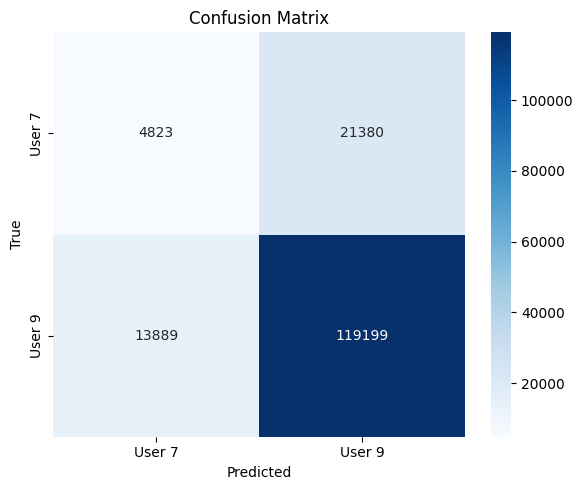

In [74]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
model.eval()

# Store ground truth and predictions
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.argmax(1).cpu().tolist())

# Print classification report with proper class names
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["User 7", "User 9"]))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["User 7", "User 9"], yticklabels=["User 7", "User 9"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

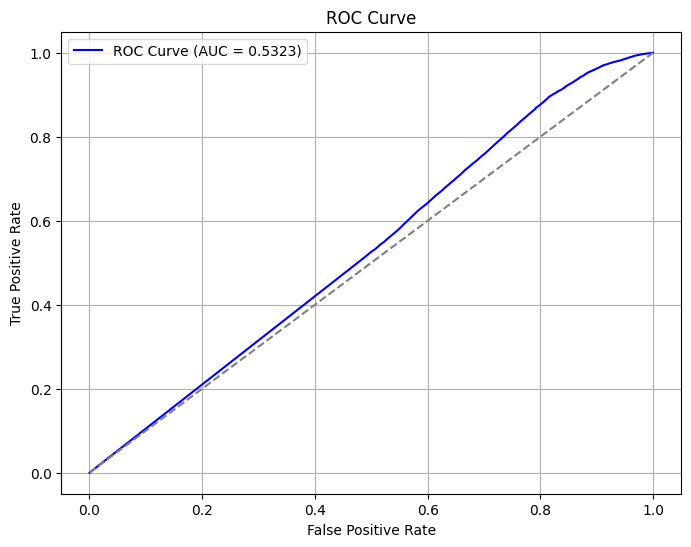

In [75]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_probs = []

model.eval()
with torch.no_grad():
    for xb, _ in val_dl:
        xb = xb.to(device)
        probs = torch.softmax(model(xb), dim=1)[:, 1]  # Probability for class 1 (User 9)
        y_probs.extend(probs.cpu().tolist())

# Compute AUC
auc = roc_auc_score(y_true, y_probs)

# Get FPR and TPR for the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], '--', color='gray')  # Diagonal line (random guessing)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()